# I) General

## 1. Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import random
import string
import re
import unicodedata
from time import time

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import svm
from sklearn import linear_model as lin
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import sklearn.naive_bayes as nb

from wordcloud import WordCloud

# II) First data set french presidents

## 1. Data visualization

In [2]:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8')
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [3]:
def preprocessing(X):
    res = []
    for doc in X:
        punc = string.punctuation
        punc += '\n\r\t'
        doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))
        doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
        doc = doc.lower()
        doc = re.sub('[0-9]+', '', doc)
        res.append(doc)
    return np.array(res)

def formal(X):
    stemmer = SnowballStemmer(language='french')
#     nltk.download('stopwords')
    res = []
    stop = stopwords.words('french')
    for doc in X:
        new_doc = ""
        for w in doc.split():
            if w not in stop:
                new_doc += w + " "
        new_doc = [stemmer.stem(X) for X in new_doc.split()]
        new_doc = " ".join(new_doc)
        res.append(new_doc)
    return res

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): 
            rt.extend(flatten(i))
        else: 
            rt.append(i)
    return rt

In [4]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)
X_preprocess = preprocessing(X)
X_train = formal(X_preprocess)

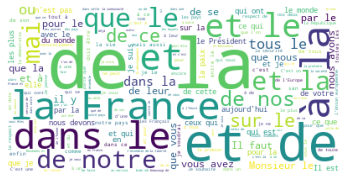

In [5]:
words = "".join(flatten(X))
wordcloud = WordCloud(background_color='white', max_words=200).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[ 0.          0.          0.         ... 10.52623909 10.69067138
 11.14232544]
['incorporations' 'incurable' 'incursions' ... 'et' 'la' 'de']


C:\Users\karna\AppData\Local\Temp/ipykernel_53652/2405479846.py:13: RuntimeWarning: divide by zero encountered in log
  ax.bar(np.arange(len(count)),np.log(count))


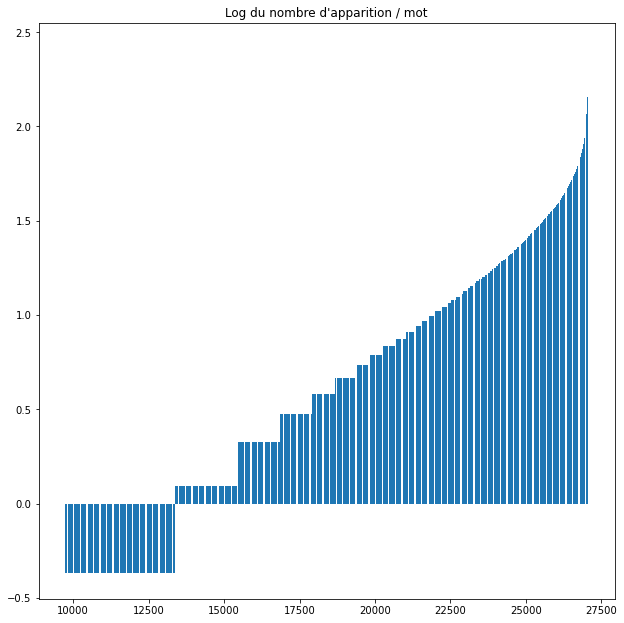

In [6]:
words = "".join(flatten(X_preprocess))
unique_words, count = np.unique(words.split(), return_counts=True)
count = np.log(count+1e-5)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(count)),np.log(count))
plt.title("Log du nombre d'apparition / mot")
plt.show()

[    1     1     1 ... 37281 43944 69032]
['incorporations' 'incurable' 'incursions' ... 'et' 'la' 'de']


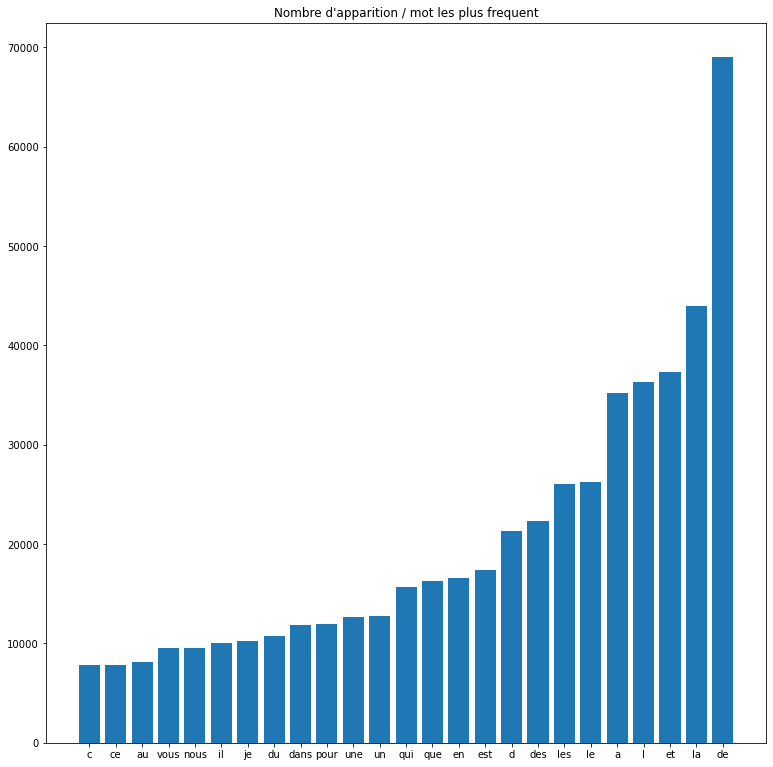

In [7]:
unique_words, count = np.unique(words.split(), return_counts=True)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_words[len(count)-25:],count[len(count)-25:])
plt.title("Nombre d'apparition / mot les plus frequent")
plt.show()

## 2. Features and model selection

In [8]:
def naive_balancing(X, Y):
    label, count = np.unique(Y, return_counts=True)
    idx_pos = np.where(Y == 1, True, False)
    Y_pos = Y[idx_pos]
    Y_pos = Y_pos[:count.min()]
    idx_neg = np.where(Y == -1, True, False)
    Y_neg = Y[idx_neg]
    new_Y = np.concatenate((Y_pos, Y_neg))
    new_X = np.concatenate((X[:count.min()], X[idx_neg]))    
    tmp = list(zip(new_X, new_Y))
    random.shuffle(tmp)
    new_X, new_Y = zip(*tmp)  
    label, count = np.unique(new_Y, return_counts=True)
    print(label, count)
    return new_X, new_Y

def get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer, transformer=None):
    X_vector = vectorizer.fit_transform(X)
    if transformer is not None:
        transformer = transformer.fit(X_vector)
        X_final = transformer.transform(X_vector)
    else:
        X_final = X_vector
    X_test_vector = vectorizer.transform(X_test)
    return X_final, X_test_vector, Y, Y_test

def get_inf_acc(predictions, Y_test):
    idx_inf = np.where(predictions==-1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def get_sup_acc(predictions, Y_test):
    idx_inf = np.where(predictions==1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def display_infos(clf, X_test, Y_test):
    # Check le nombre de predictions pour chaque label
    predictions = clf.predict(X_test)
    unique, counts = np.unique(predictions, return_counts=True)
    print("/!\ Prediction counts for label ", unique, " --> ", counts)
    # Check le nombre de predictions pour chaque label
    unique, counts = np.unique(Y_test, return_counts=True)
    print("/!\ Ground truth counts for label ", unique, " --> ", counts)
    # Check la precision du label en inferiorite
    acc = get_inf_acc(predictions, Y_test)
    print("/!\ Accuracy of inferior label :", acc, "%")
    # Check la precision du label en superiorite
    acc = get_sup_acc(predictions, Y_test)
    print("/!\ Accuracy of superior label :", acc, "%\n")
    
def display_model_scores(model, X_test, Y_test):
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(best_parameters.keys()):
        print("--->%s: %r" % (param_name, best_parameters[param_name]))
    print(model.best_score_)
    grid_predictions = model.predict(X_test)
    print(confusion_matrix(Y_test, grid_predictions))
    print(classification_report(Y_test, grid_predictions))
    
def stemm(X):
    stemmer = SnowballStemmer("french")
    stem = stemmer.stem(X)
    return X

In [10]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)
new_X, new_Y = naive_balancing(X,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) # Test avec new_X, new_Y
train_size = len(X_train)
test_size = len(X_test)
print(train_size)
print(test_size)

[-1  1] [7523 7523]
45930
11483


In [11]:
# Remove comments for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)
# for i in range(len(X_test)):
#     stemmer.stemWords(X_test[i].split()[j] for j in range(len(X_test[i].split())))

In [12]:
search = False

In [13]:
sw = stopwords.words('french')

if search :

    # Search with booleans
    pipeline1 = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", svm.SVC()),
        ]
    )
    parameters1 = {
        "vect__lowercase": (True, False),
        "vect__stop_words": (None, sw),
        "vect__strip_accents": (None, "ascii"),
        "vect__use_idf": (True, False),
        "vect__smooth_idf": (True, False),
        "vect__use_idf": (True, False),
        "vect__sublinear_tf": (True, False),
        
        "vect__min_df": (1,),
        "vect__max_df": (0.1,),
        "vect__ngram_range": [(1, 2),],
        'vect__max_features': (None,),

        "clf__C": (10,100),
        'clf__class_weight':(["balanced"]),
        'clf__kernel':(['linear']),               
        "clf__max_iter": (1000,)
    }
    
    # Search with numerical values
    pipeline2 = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", svm.SVC()),
        ]
    )
    parameters2 = {
        # "vect__lowercase": (False,),
        # "vect__stop_words": (None,),
        # "vect__strip_accents": ('ascii',),
        # "vect__use_idf": (True,),
        # "vect__smooth_idf": (False,),
        # "vect__sublinear_tf": (False,),
        
        "vect__min_df": (1,),
        "vect__max_df": (0.001,),
        "vect__ngram_range": [(1, 2),],
        'vect__max_features': (None,),
        
        "clf__C": (10000,),
        'clf__class_weight':(["balanced"]),
        'clf__kernel':(['linear']),               
        "clf__max_iter": (1000,)
    }
    
    # Search with everything
    pipeline3 = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", svm.SVC()),
        ]
    )
    parameters3 = {
        "vect__lowercase": (False,True),
        "vect__stop_words": (None,sw),
        "vect__strip_accents": (None, 'ascii'),
        # "vect__use_idf": (True,False),
        # "vect__smooth_idf": (False,True),
        # "vect__sublinear_tf": (False,True),
        
        "vect__min_df": (1, 3, 10, 25),
        "vect__max_df": (0.05,0.1,0.5,0.9),
        "vect__ngram_range": [(1, 1),(1, 2)],
        'vect__max_features': (None,),
        
        "clf__C": (200, 500),
        'clf__class_weight':(["balanced"]),
        'clf__kernel':(['linear']),               
        "clf__max_iter": (1000,) # test higher 
    }

    grid_search_parameters = GridSearchCV(pipeline3, 
                                          parameters3, 
                                          scoring="f1", # test "rog_auc"
                                          n_jobs=8, 
                                          verbose=3, 
                                          cv=3,
                                          refit=True
                                          )
    
    t0 = time()
    grid_search_parameters.fit(X_train, Y_train) # test and compare f1 score if pipeline 1 -> pipeline 2 or pipeline 2 -> pipeline 1
    print("done in %0.3fs" % (time() - t0))

In [14]:
if search :
    # display_model_scores(grid_search_parameters, X_train, Y_train)
    display_model_scores(grid_search_parameters, X_test, Y_test)

In [16]:
vectorizer = TfidfVectorizer(lowercase=False,
                             stop_words=None,
                             strip_accents=None,
                             use_idf=True,
                             smooth_idf=True,
                             sublinear_tf=False,
                             
                             min_df=1,
                             max_df=0.05,
                             ngram_range=(1,2),
                            )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector, X_test_vector, Y_train, Y_test = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer)
print(X_train_vector.shape)

(45930, 307984)


In [17]:
if search:
    parameters = {
        'C': ([200]),
        'gamma': (["scale"]),
        'class_weight':(["balanced"]),
        'kernel':(['linear'])  
        # "max_iter": (1000,)
    }

    optimal_model = GridSearchCV(svm.SVC(),
                                 parameters, 
                                 scoring="f1", # test "rog_auc"
                                 n_jobs=8, 
                                 verbose=3, 
                                 cv=3,
                                 refit=True
                                 )

    t0 = time()
    optimal_model.fit(X_train_vector[:train_size], Y_train[:train_size])
    print("done in %0.3fs" % (time() - t0))

In [18]:
if search:
    # display_model_scores(optimal_model, X_train_vector, Y_train)
    display_model_scores(optimal_model, X_test_vector, Y_test)

## 3. Final training

In [21]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts_train_final, alllabs_train_final = load_pres(fname)
X_train_final = np.array(alltxts_train_final)
Y_train_final = np.array(alllabs_train_final)

In [ ]:
final_vectorizer = TfidfVectorizer(lowercase=False,
                                   stop_words=None,
                                   strip_accents=None,
                                   use_idf=True,
                                   smooth_idf=True,
                                   sublinear_tf=False,
                             
                                   min_df=1,
                                   max_df=0.05,
                                   ngram_range=(1,2),
                                   )

X_final_vector = final_vectorizer.fit_transform(X_train_final)

final_model = svm.SVC(C=200, 
                      gamma="scale",
                      class_weight="balanced", 
                      kernel="linear",
                      verbose=3,
                      )

t0 = time()
final_model.fit(X_final_vector,  Y_train_final)
print("done in %0.3fs" % (time() - t0))

[LibSVM]

## 4. Computing final results

In [ ]:
fname = "data/corpus.tache1.test.utf8"
alltxts_test_final, alllabs_test_final = load_pres(fname)
X_test_final = np.array(alltxts_test)
Y_test_final = np.array(alllabs_test)

In [ ]:
X_test_vector = final_vectorizer.transform(X_test_final)
final_pred = final_model.predict(X_test_vector)

In [ ]:
print(final_pred)

In [ ]:
f = open("output/preds_clean.txt", "a")
preds = ""
for i in range(len(final_pred)):
    preds += str(final_pred[i])
# print(preds)
f.write(preds)
f.close()

## 5. Post processing

# III) Movie dataset